# <h1 align="center">Trabajo Practico 1: UdeSA Panoramica</h1>

In [1]:
import matplotlib.pyplot as plt
import cv2
from utils import imshow, show_images
import numpy as np

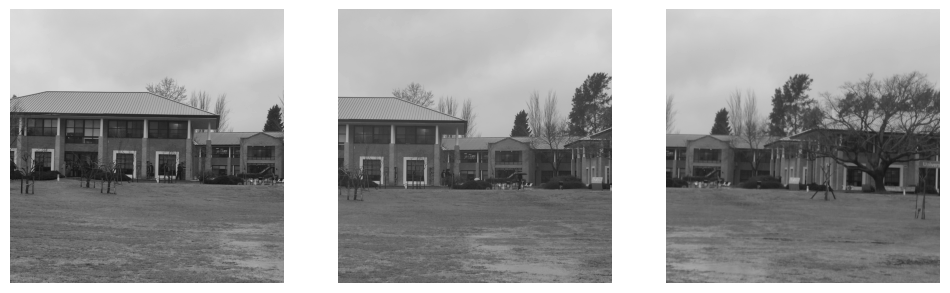

In [2]:
images = [cv2.imread(f'img/udesa_{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(3)]
show_images(images)

## Deteccion y Descripcion de Caracteristicas Visuales

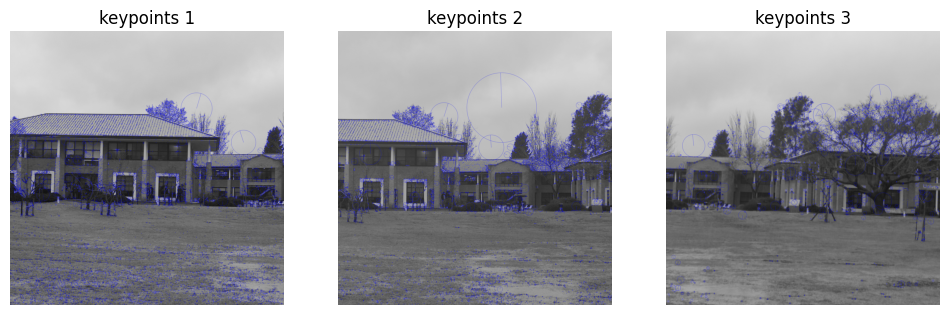

In [3]:
sift_algo = cv2.SIFT_create()
images_keypoints = []
images_descriptors = []

for i in range(len(images)):
    kp, des = sift_algo.detectAndCompute(images[i], None)
    images_keypoints.append(kp)
    images_descriptors.append(des)

images_with_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        img_bgr,
        images_keypoints[i],
        0, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_kp.append(img_with_kp)

show_images(images_with_kp, ["keypoints 1", "keypoints 2", "keypoints 3"])

In [4]:
def apply_anms_to_keypoints_with_indices(keypoints, N=10000):
    """
    Adaptive Non-Maximal Suppression (ANMS) that returns indices of keypoints.
    
    Parameters:
      keypoints: list of cv2.KeyPoint
      N: maximum number of keypoints to keep
    
    Returns:
      List of indices corresponding to the selected keypoints.
    """
    if not keypoints:
        return []
    
    n = len(keypoints)
    # R will hold the suppression radius for each keypoint.
    R = [float('inf')] * n
    
    # Compute R[i]: the minimum distance to any keypoint with a higher response.
    for i, kp in enumerate(keypoints):
        for j, kp_j in enumerate(keypoints):
            if kp_j.response > kp.response:
                dist = np.sqrt((kp.pt[0] - kp_j.pt[0])**2 + (kp.pt[1] - kp_j.pt[1])**2)
                if dist < R[i]:
                    R[i] = dist
    
    # Sort indices by their suppression radius, largest first.
    sorted_indices = sorted(range(n), key=lambda i: R[i], reverse=True)
    
    # Return the top N indices, sorted in ascending order (if order matters downstream).
    return sorted(sorted_indices[:N])

# Assuming images_keypoints and images_descriptors are lists corresponding to each image:
anms_indices = [apply_anms_to_keypoints_with_indices(kp_list, N=10000)
                for kp_list in images_keypoints]

# Create filtered descriptors and keypoints lists
filtered_descriptors = []
filtered_keypoints = []
for i, indices in enumerate(anms_indices):
    filtered_descriptors.append(images_descriptors[i][indices])
    filtered_keypoints.append([images_keypoints[i][idx] for idx in indices])

images_descriptors = filtered_descriptors

# Visualize ANMS keypoints
images_with_anms_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_anms_kp = cv2.drawKeypoints(
        img_bgr,
        filtered_keypoints[i],
        None, (0, 255, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_anms_kp.append(img_with_anms_kp)
    
show_images(images_with_anms_kp, ["ANMS keypoints 1", "ANMS keypoints 2", "ANMS keypoints 3"])

print(len(anms_indices[0]), len(anms_indices[1]), len(anms_indices[2]))

KeyboardInterrupt: 

## Asociacion de Caracteristicas

### Cross-check

Matches between image 0 and image 1: 5228
Matches between image 1 and image 2: 2177


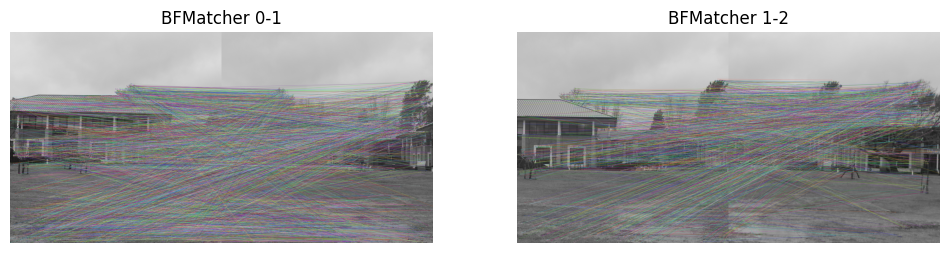

In [54]:
# Create BFMatcher object with L2 norm (for SIFT, SURF, etc.) and crossCheck enabled.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

def bf_cross_check(desc1, desc2, matcher):
    # Ensure descriptors are float32 if necessary.
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    
    # Perform matching. With crossCheck=True, only mutual matches are returned.
    matches = matcher.match(desc1, desc2)
    
    # Optionally, sort matches by distance (lower distance is better).
    return sorted(matches, key=lambda x: x.distance)

# Matching between image 0 and image 1.
matches01_cross = bf_cross_check(images_descriptors[0], images_descriptors[1], bf)
matched_img01_cross = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Matching between image 1 and image 2.
matches12_cross = bf_cross_check(images_descriptors[1], images_descriptors[2], bf)
matched_img12_cross = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the matching images.
show_images([matched_img01_cross, matched_img12_cross], ["BFMatcher 0-1", "BFMatcher 1-2"])
print(f"Matches between image 0 and image 1: {len(matches01_cross)}")
print(f"Matches between image 1 and image 2: {len(matches12_cross)}")

 ### Lowe´s Ratio

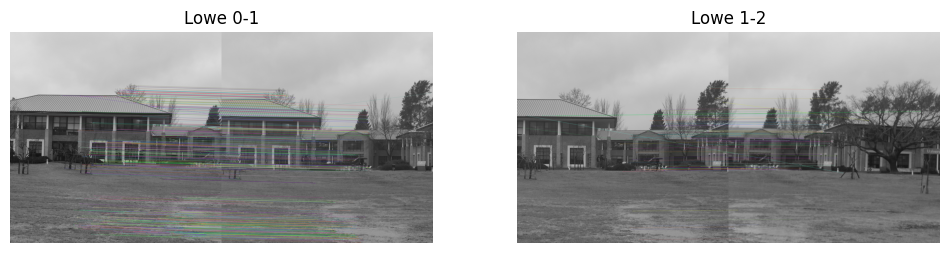

In [55]:
# Create BFMatcher object with L2 norm (e.g., for SIFT, SURF descriptors).
bf = cv2.BFMatcher(cv2.NORM_L2)

def bf_lowe_test(desc1, desc2, ratio=0.6):
    # Ensure descriptors are float32.
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    
    # Retrieve the two nearest neighbors for each descriptor.
    knn_matches = bf.knnMatch(desc1, desc2, k=2)
    
    # Apply Lowe's ratio test.
    good_matches = [m for m, n in knn_matches if m.distance < ratio * n.distance]
    return good_matches

# Matching between image 0 and image 1.
matches01_lowe = bf_lowe_test(images_descriptors[0], images_descriptors[1])
matched_img01_lowe = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Matching between image 1 and image 2.
matches12_lowe = bf_lowe_test(images_descriptors[1], images_descriptors[2])
matched_img12_lowe = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the resulting matching images.
show_images([matched_img01_lowe, matched_img12_lowe], ["Lowe 0-1", "Lowe 1-2"])


### Cross-check vs Lowe´s Ratio

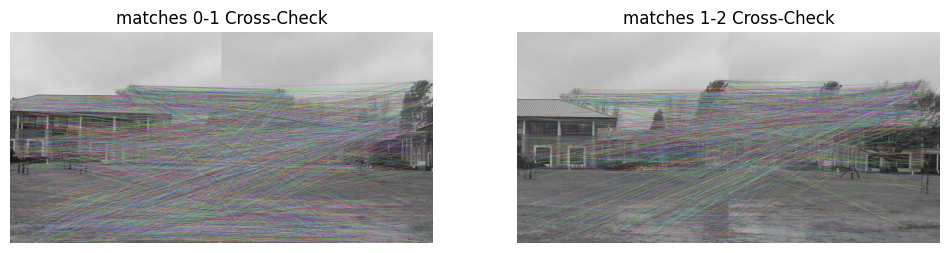

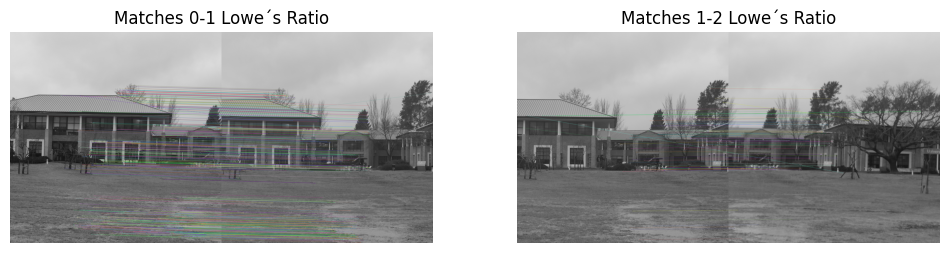

In [56]:
show_images([matched_img01_cross, matched_img12_cross], ["matches 0-1 Cross-Check", "matches 1-2 Cross-Check"])
show_images([matched_img01_lowe, matched_img12_lowe], ["Matches 0-1 Lowe´s Ratio", "Matches 1-2 Lowe´s Ratio"])

In [57]:
def normalize_points(points):
    """
    Normalize a set of 2D points so that the centroid is at the origin and the average distance to the origin is sqrt(2).
    Returns the normalized points in homogeneous coordinates and the normalization matrix.
    """
    points = np.array(points)
    # Compute centroid
    centroid = np.mean(points, axis=0)
    # Shift origin to centroid
    shifted = points - centroid
    # Compute scale such that average distance is sqrt(2)
    dists = np.linalg.norm(shifted, axis=1)
    mean_dist = np.mean(dists)
    scale = np.sqrt(2) / mean_dist

    # Construct normalization matrix
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0,    0,                  1]])
    
    # Convert points to homogeneous coordinates and normalize
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])
    normalized_points = (T @ points_hom.T).T

    return normalized_points, T

def dlt(ori, dst):
    """
    Compute the homography matrix using the Direct Linear Transformation (DLT) algorithm
    with point normalization and SVD for improved numerical stability.
    """
    ori = np.array(ori)
    dst = np.array(dst)
    
    # Normalize points
    norm_ori, T_ori = normalize_points(ori)
    norm_dst, T_dst = normalize_points(dst)

    # Build matrix A using normalized points
    A = []
    for i in range(4):
        x, y, _ = norm_ori[i]
        xp, yp, _ = norm_dst[i]
        A.append([-x, -y, -1,  0,  0,  0, x * xp, y * xp, xp])
        A.append([ 0,  0,  0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)

    # Solve for h using SVD (the solution is the last column of V or last row of V^T)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]
    H_normalized = h.reshape(3, 3)

    # Denormalize: H = inv(T_dst) * H_normalized * T_ori
    H = np.linalg.inv(T_dst) @ H_normalized @ T_ori

    # Normalize H so that H[2,2] is 1
    H /= H[2, 2]

    return H

def apply_homography(H, points):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed_points = points_homogeneous @ H.T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def compute_precision(original_points, transformed_points):
    errors = np.linalg.norm(original_points - transformed_points, axis=1)
    return np.mean(errors)

p0 = [
    [2304, 1157],
    [2756, 1360],
    [2930, 1038],
    [2597, 1685],
]

p1 = [
    [1407, 1219],
    [1873, 1407],
    [2025, 1096],
    [1721, 1732],
    [2022, 1548]
]

p2 = [
    [466, 1381],
    [651, 1067],
    [311, 1714],
    [611, 1522]
]

p0_matched = np.array(p0)
p1_matched = np.array(p1[:-1])
H1 = dlt(p0_matched, p1_matched)

p1_matched_2 = np.array(p1[1:])
p2_matched = np.array(p2)
H2 = dlt(p1_matched_2, p2_matched)

p0_to_p1_transformed = apply_homography(H1, p0_matched)
p1_to_p2_transformed = apply_homography(H2, p1_matched_2)

precision_p0_p1 = compute_precision(p1_matched, p0_to_p1_transformed)
precision_p1_p2 = compute_precision(p2_matched, p1_to_p2_transformed)

precision_p0_p1, precision_p1_p2


(1.3245827965187746e-12, 7.147342799176322e-12)

## RANSAC

In [58]:
def ransac_homography_from_matches(kp1: list, kp2: list, matches: list, max_iterations: int = 1000, threshold: float = 5.0):
    max_inliers = 0
    best_inliers = []
    best_H = None

    for _ in range(max_iterations):
        sample_matches = np.random.choice(matches, 4, replace=False)

        # Get the point correspondences
        points1 = [kp1[m.queryIdx].pt for m in sample_matches]
        points2 = [kp2[m.trainIdx].pt for m in sample_matches]

        # Estimate homography using the improved DLT
        H = dlt(points1, points2)

        inliers = []
        for m in matches:
            pt1 = np.array([*kp1[m.queryIdx].pt, 1], dtype=np.float32)
            pt2 = np.array([*kp2[m.trainIdx].pt, 1], dtype=np.float32)

            projected_pt = H @ pt1
            projected_pt /= projected_pt[2]  # Normalize homogeneous coordinates
            # Calculate distance in image plane (x, y)
            distance = np.linalg.norm(projected_pt[:2] - pt2[:2])

            if distance < threshold:
                inliers.append(m)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers
            best_H = H

    return best_H, best_inliers

ransac_01_H, ransac_01_inliers = ransac_homography_from_matches(
    images_keypoints[0], images_keypoints[1], matches01_lowe, max_iterations=1000, threshold=5.0
)
ransac_12_H, ransac_12_inliers = ransac_homography_from_matches(
    images_keypoints[1], images_keypoints[2], matches12_lowe, max_iterations=1000, threshold=5.0
)

print(f"RANSAC 0-1: {len(ransac_01_inliers)} inliers")
print(f"RANSAC 1-2: {len(ransac_12_inliers)} inliers")


RANSAC 0-1: 776 inliers
RANSAC 1-2: 74 inliers


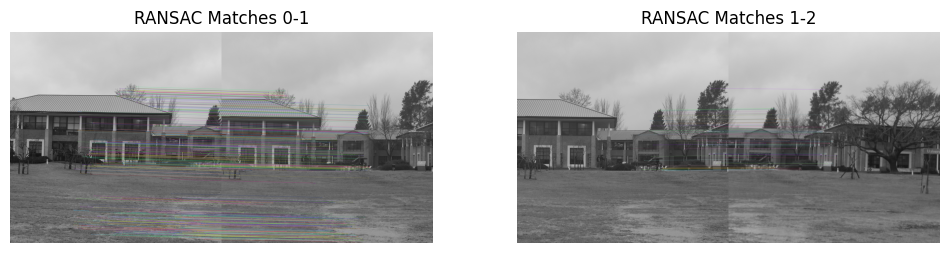

In [59]:
# Draw inliers
inlier_matches_01 = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    ransac_01_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
inlier_matches_12 = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    ransac_12_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
show_images([inlier_matches_01, inlier_matches_12], ["RANSAC Matches 0-1", "RANSAC Matches 1-2"])

In [60]:
# Extraer puntos de los inliers 0-1
pts_01_src = np.float32([images_keypoints[0][m.queryIdx].pt for m in ransac_01_inliers])
pts_01_dst = np.float32([images_keypoints[1][m.trainIdx].pt for m in ransac_01_inliers])

# Homografía usando OpenCV
H_cv2_01, mask_01 = cv2.findHomography(pts_01_src, pts_01_dst)

# Repetir para imágenes 1-2
pts_12_src = np.float32([images_keypoints[1][m.queryIdx].pt for m in ransac_12_inliers])
pts_12_dst = np.float32([images_keypoints[2][m.trainIdx].pt for m in ransac_12_inliers])

H_cv2_12, mask_12 = cv2.findHomography(pts_12_src, pts_12_dst)

print("Homografía 0 → 1 (OpenCV):\n", H_cv2_01)
print("Homografía 1 → 2 (OpenCV):\n", H_cv2_12)


Homografía 0 → 1 (OpenCV):
 [[ 1.05886204e+00  1.16146837e-02 -9.72947546e+02]
 [ 1.83904002e-02  1.03511763e+00  2.29213143e+01]
 [ 1.65422041e-05  6.74125054e-07  1.00000000e+00]]
Homografía 1 → 2 (OpenCV):
 [[ 1.10918047e+00 -4.89541747e-02 -1.51295425e+03]
 [ 8.78724122e-02  1.07341774e+00 -2.08793426e+02]
 [ 3.51630090e-05 -3.98664084e-06  1.00000000e+00]]


j
j
limites -973 -174 4609 3122


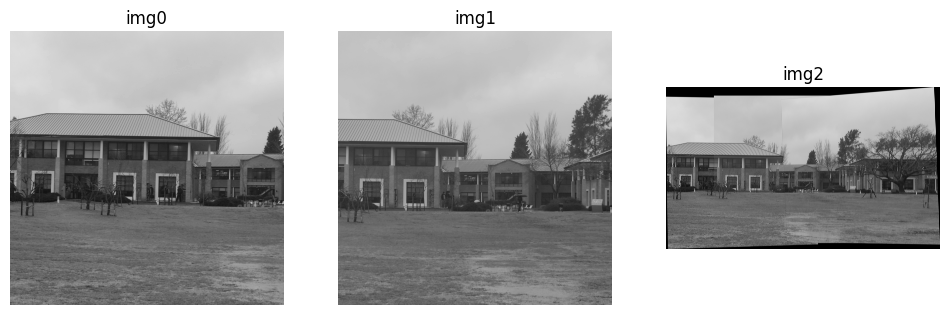

In [61]:
def cylindrical_warp(img, f):
    h, w = img.shape[:2]
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    xs_c = xs - w / 2
    ys_c = ys - h / 2
    theta = np.arctan(xs_c / f)
    h_ = ys_c / np.sqrt(xs_c**2 + f**2)
    map_x = (f * theta + w / 2).astype(np.float32)
    map_y = (f * h_ + h / 2).astype(np.float32)
    cyl = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return cyl


H0 = H_cv2_01
H1 = np.eye(3)
H2 = np.linalg.inv(H_cv2_12)
H_matrices = [H0, H1, H2]

focal_length = 500 # hay que buscar esto
images = [cv2.cvtColor(plt.imread(f'img/udesa_{i}.jpg'), cv2.COLOR_RGB2GRAY) for i in range(3)] # esto lo redefini porq estaba bug
print("j")
show_images(images,['img0','img1','img2']) # decime si te muestra las imagenes bien
print("j")
images_cyl = images
# images_cyl = [cylindrical_warp(img, focal_length) for img in images] # esto lo comente por ahora, despues vemos

def compute_panorama_bounds(images, H_matrices):
    all_corners = []
    for img, H in zip(images, H_matrices):
        h, w = img.shape[:2]
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners, H)
        all_corners.append(warped_corners)
    all_corners = np.vstack(all_corners)
    x_min = int(np.floor(all_corners[:, 0, 0].min()))
    y_min = int(np.floor(all_corners[:, 0, 1].min()))
    x_max = int(np.ceil(all_corners[:, 0, 0].max()))
    y_max = int(np.ceil(all_corners[:, 0, 1].max()))
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = compute_panorama_bounds(images_cyl, H_matrices)
print("limites", x_min, y_min, x_max, y_max)

translation = np.array([[1, 0, -x_min],
                        [0, 1, -y_min],
                        [0, 0, 1]])
pano_width = x_max - x_min
pano_height = y_max - y_min

warped_images = []
for idx, (img, H) in enumerate(zip(images_cyl, H_matrices)):
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    warped = cv2.warpPerspective(img, translation @ H, (pano_width, pano_height))
    warped_images.append(warped)
    imshow(warped)

panorama = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)
for warped in warped_images:
    mask = (warped > 0)
    panorama[mask] = warped[mask]

imshow(panorama)
